## Unsupervised Learning

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')

- ### Clustering: K-Means

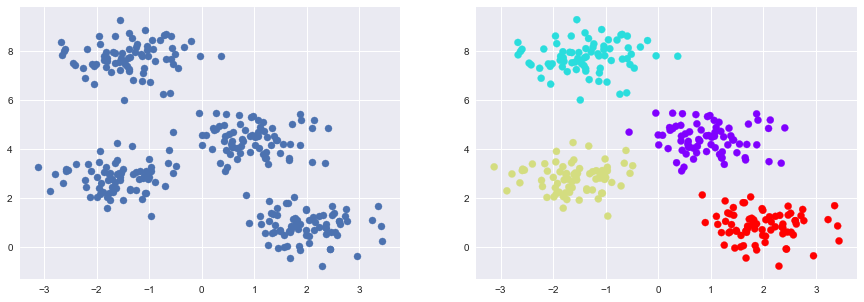

In [3]:
######################################################################
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], s=50);

######################################################################
from sklearn.cluster import KMeans
est = KMeans(4)  # 4 clusters
est.fit(X)
y_kmeans = est.predict(X)
plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

The search space would be exponential in the number of points. Fortunately, there is a well-known **Expectation Maximization (EM)** procedure which scikit-learn implements

- ### The K-Means Algorithm: Expectation Maximization

Expectation-Maximization is a two-step approach which works as follows:

 - Guess some cluster centers
 - Repeat until converged A. Assign points to the nearest cluster center B. Set the cluster centers to the mean

#### KMeans Caveats
The convergence of this algorithm is not guaranteed; for that reason, scikit-learn by default uses a large number of random initializations and finds the best results.

Also, the number of clusters must be set beforehand

There are other clustering algorithms for which this requirement may be lifted.

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

def plot_kmeans_interactive(min_clusters=1, max_clusters=6):
    from ipywidgets import interact
    from sklearn.metrics.pairwise import euclidean_distances
    from sklearn.datasets.samples_generator import make_blobs

    with warnings.catch_warnings():
        warnings.filterwarnings('ignore')

        X, y = make_blobs(n_samples=300, centers=4,
                          random_state=0, cluster_std=0.60)

        def _kmeans_step(frame=0, n_clusters=4):
            rng = np.random.RandomState(2)
            labels = np.zeros(X.shape[0])
            centers = rng.randn(n_clusters, 2)

            nsteps = frame // 3

            for i in range(nsteps + 1):
                old_centers = centers
                if i < nsteps or frame % 3 > 0:
                    dist = euclidean_distances(X, centers)
                    labels = dist.argmin(1)

                if i < nsteps or frame % 3 > 1:
                    centers = np.array([X[labels == j].mean(0)
                                        for j in range(n_clusters)])
                    nans = np.isnan(centers)
                    centers[nans] = old_centers[nans]


            # plot the data and cluster centers
            plt.scatter(X[:, 0], X[:, 1], c=labels, s=50, cmap='rainbow',
                        vmin=0, vmax=n_clusters - 1);
            plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                        c=np.arange(n_clusters),
                        s=200, cmap='rainbow')
            plt.scatter(old_centers[:, 0], old_centers[:, 1], marker='o',
                        c='black', s=50)

            # plot new centers if third frame
            if frame % 3 == 2:
                for i in range(n_clusters):
                    plt.annotate('', centers[i], old_centers[i], 
                                 arrowprops=dict(arrowstyle='->', linewidth=1))
                plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                            c=np.arange(n_clusters),
                            s=200, cmap='rainbow')
                plt.scatter(centers[:, 0], centers[:, 1], marker='o',
                            c='black', s=50)

            plt.xlim(-4, 4)
            plt.ylim(-2, 10)

            if frame % 3 == 1:
                plt.text(3.8, 9.5, "1. Reassign points to nearest centroid",
                         ha='right', va='top', size=14)
            elif frame % 3 == 2:
                plt.text(3.8, 9.5, "2. Update centroids to cluster means",
                         ha='right', va='top', size=14)

    
    return interact(_kmeans_step, frame=(0, 50),
                    n_clusters=[min_clusters, max_clusters])


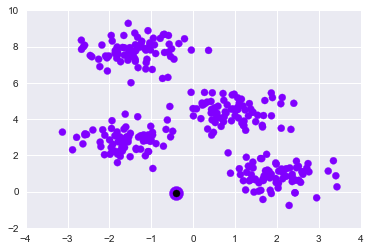

In [15]:
plot_kmeans_interactive();

- ### Application of KMeans to Digits

(10, 64)


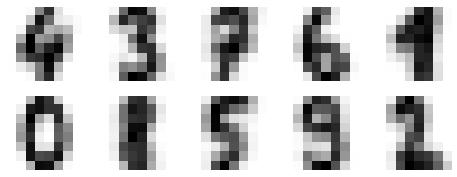

In [4]:
from sklearn.datasets import load_digits
digits = load_digits()

est = KMeans(n_clusters=10)
clusters = est.fit_predict(digits.data)
print(est.cluster_centers_.shape)

fig = plt.figure(figsize=(8, 3))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    ax.imshow(est.cluster_centers_[i].reshape((8, 8)), cmap=plt.cm.binary)

In [7]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

0.7918753478018921


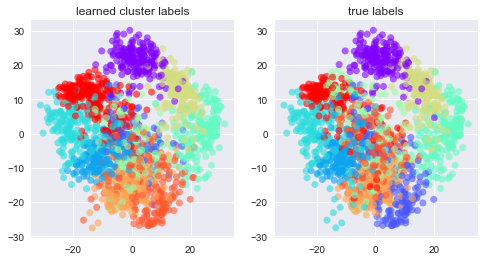

In [9]:
from sklearn.decomposition import PCA

X = PCA(2).fit_transform(digits.data)

kwargs = dict(cmap = plt.cm.get_cmap('rainbow', 10),
              edgecolor='none', alpha=0.6)
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(X[:, 0], X[:, 1], c=labels, **kwargs)
ax[0].set_title('learned cluster labels')

ax[1].scatter(X[:, 0], X[:, 1], c=digits.target, **kwargs)
ax[1].set_title('true labels');

from sklearn.metrics import accuracy_score
print(accuracy_score(digits.target, labels))

[[177   0   0   0   1   0   0   0   0   0]
 [  0  55  24   1   0   1   2   0  99   0]
 [  1   2 148  13   0   0   0   3   8   2]
 [  0   0   1 157   0   2   0   7   7   9]
 [  0   5   0   0 164   0   0  10   2   0]
 [  0   0   0   1   2 136   1   0   0  42]
 [  1   1   0   0   0   0 177   0   2   0]
 [  0   2   0   0   0   5   0 170   2   0]
 [  0   6   3   3   0   6   2   3 100  51]
 [  0  20   0   6   0   7   0   8   0 139]]


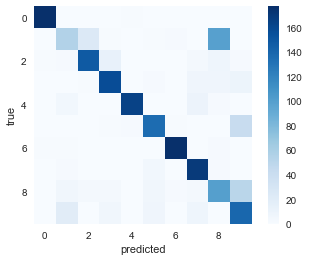

In [10]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(digits.target, labels))

plt.imshow(confusion_matrix(digits.target, labels),
           cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.grid(False)
plt.ylabel('true')
plt.xlabel('predicted');

- ### Example: KMeans for Color Compression

(427, 640, 3)
(273280, 3)


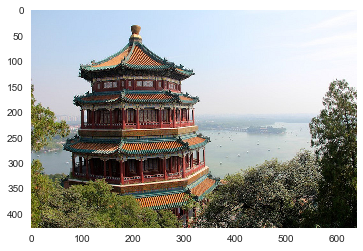

In [11]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
plt.imshow(china)
plt.grid(False);

print(china.shape)
X = (china / 255.0).reshape(-1, 3)
print(X.shape)

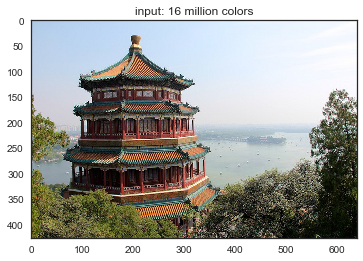

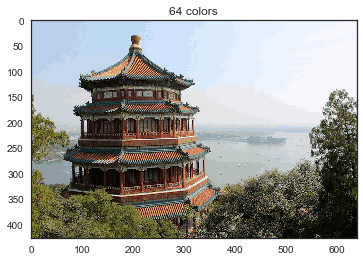

In [12]:
from sklearn.cluster import MiniBatchKMeans

# reduce the size of the image for speed
n_colors = 64

X = (china / 255.0).reshape(-1, 3)
    
model = MiniBatchKMeans(n_colors)
labels = model.fit_predict(X)
colors = model.cluster_centers_
new_image = colors[labels].reshape(china.shape)
new_image = (255 * new_image).astype(np.uint8)

# create and plot the new image
with plt.style.context('seaborn-white'):
    plt.figure()
    plt.imshow(china)
    plt.title('input: 16 million colors')

    plt.figure()
    plt.imshow(new_image)
    plt.title('{0} colors'.format(n_colors))

- ### Density Estimation: Gaussian Mixture Models

Gaussian Mixture Models, which is an unsupervised clustering & density estimation technique.

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

plt.style.use('seaborn')

Here we'll consider an extension to this which is suitable for both clustering and density estimation.

C:\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


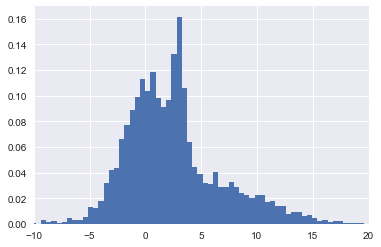

In [15]:
np.random.seed(2)
x = np.concatenate([np.random.normal(0, 2, 2000),
                    np.random.normal(5, 5, 2000),
                    np.random.normal(3, 0.5, 600)])
plt.hist(x, 80, normed=True)
plt.xlim(-10, 20);

Gaussian mixture models will allow us to approximate this density:

In [18]:
from sklearn.mixture import GMM

X = x[:, np.newaxis]
clf = GMM(4, n_iter=500, random_state=3).fit(X)
xpdf = np.linspace(-10, 20, 1000)
density = np.exp(clf.score(xpdf[:, np.newaxis]))

plt.hist(x, 80, normed=True, alpha=0.5)
plt.plot(xpdf, density, '-r')
plt.xlim(-10, 20);

ImportError: cannot import name 'GMM'

GMM is what's known as a **Generative Model**: it's a probabilistic model from which a dataset can be generated. 

One thing that generative models can be useful for is **outlier detection**: 
- we can simply evaluate the likelihood of each point under the generative model; 
- the points with a suitably low likelihood (where "suitable" is up to your own bias/variance preference) can be labeld outliers.